# USB Wifi Example

In this notebook, a wifi dongle has been plugged into the board. Specifically a RALink wifi dongle commonly used with Raspberry Pi kits is connected into the board.  Using Linux calls and Python functions, we will determine the unique name of the dongle and then create a network entry for a known ssid/password pair.  This demo was first done using an iPhone hotspot wireless connection.

References <br>
http://www.canakit.com/raspberry-pi-wifi.html <br>

#### 1. Need to find Wifi Device using Linux calls

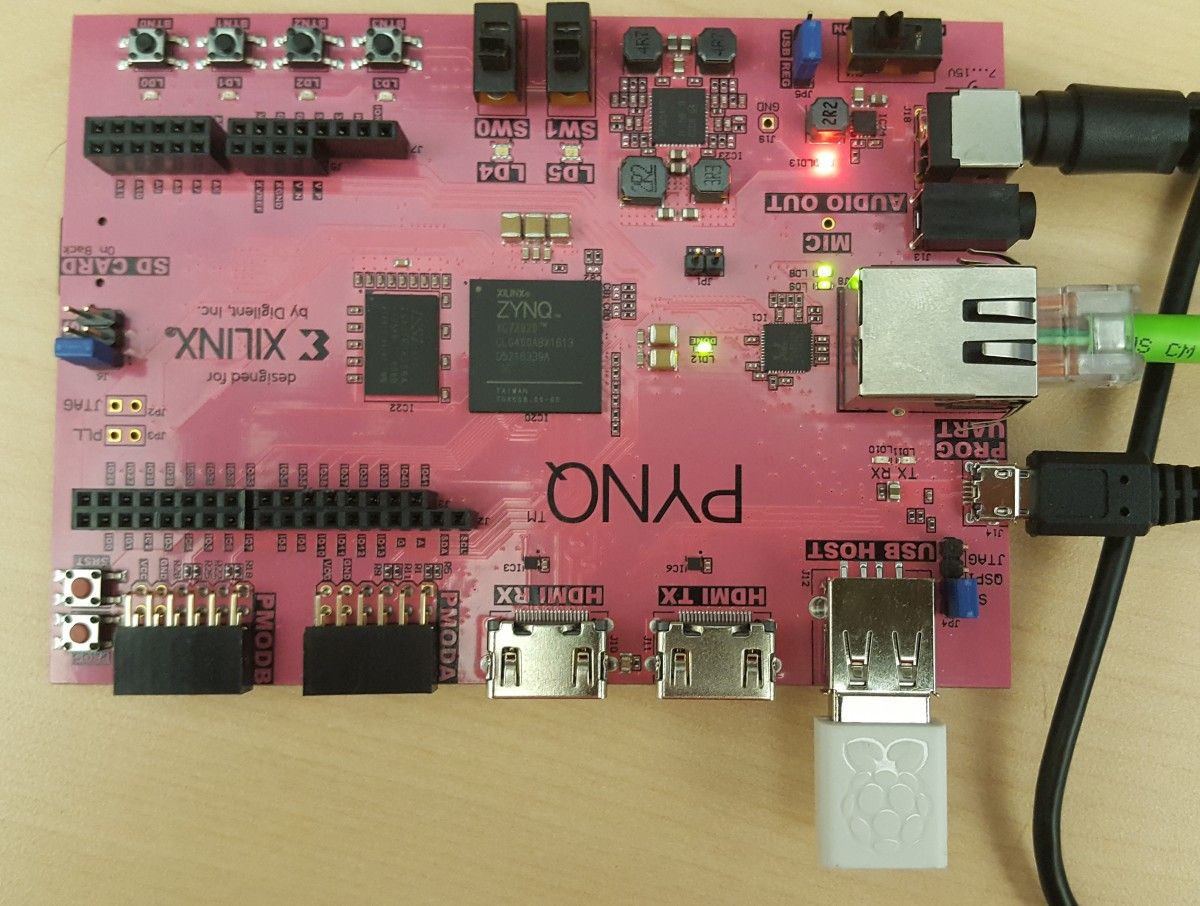

In [7]:
from IPython.display import Image
orig_img_path = '/home/xilinx/jupyter_notebooks/Examples/data/wifi.jpg'
Image(filename=orig_img_path)

In [1]:
network_devices_bash_str = !ip a
network_devices_bash_str.l

['1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default ',
 '    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00',
 '    inet 127.0.0.1/8 scope host lo',
 '       valid_lft forever preferred_lft forever',
 '    inet6 ::1/128 scope host ',
 '       valid_lft forever preferred_lft forever',
 '2: eth0: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc pfifo_fast state UP group default qlen 1000',
 '    link/ether 00:18:3e:02:3c:41 brd ff:ff:ff:ff:ff:ff',
 '    inet 172.20.9.189/22 brd 172.20.11.255 scope global eth0',
 '       valid_lft forever preferred_lft forever',
 '    inet6 fe80::218:3eff:fe02:3c41/64 scope link ',
 '       valid_lft forever preferred_lft forever',
 '3: wlxd47bb07e9ffa: <BROADCAST,MULTICAST> mtu 1500 qdisc pfifo_fast state DOWN group default qlen 1000',
 '    link/ether d4:7b:b0:7e:9f:fa brd ff:ff:ff:ff:ff:ff']

#### 2. Use Python regular expressions to get wifi port name

In [2]:
#2. 
import re

for line in network_devices_bash_str.l:
    m = re.match('^([\d]): ([\w]+): *', line)
    if m:
        if m.group(2) != 'lo' and m.group(2) != 'eth0':
            wifi_port = m.group(2)

wifi_port

'wlxd47bb07e9ffa'

#### 3. Generate the correct /etc/network/interfaces.d entry

In [3]:
def gen_network_password_file(wifi_port,ssid,password):

    # get bash string into string format for key search
    wifikey_bash_str = !wpa_passphrase $ssid $password
    wifikey_tokens = str(wifikey_bash_str).replace("'",'').split(',')
    
    # search clean list for tpsk key value
    for key_val in wifikey_tokens:
        if '\\tpsk=' in key_val:
            wifi_wpa_key = key_val.split('=')[1]
    
    # write the network interface file with new ssid/password entry
    !ip link set $wifi_port up
    
    net_iface_fh = open("/etc/network/interfaces.d/" + wifi_port, 'w')
    net_iface_fh.write("iface " + wifi_port + " inet dhcp\n")
    net_iface_fh.write(" wpa-ssid " + ssid + "\n")
    net_iface_fh.write(" wpa-psk " +   wifi_wpa_key + "\n\n")
    net_iface_fh.close()
        
    !ifup {wifi_port}


#### 4. Call the above function with ssid/password for your wifi network

In [4]:
# Do custom ssid/password for your wifi connection - below is example from iPhone hotspot
gen_network_password_file(wifi_port,'iPhone','iphonehs')

Internet Systems Consortium DHCP Client 4.3.1
Copyright 2004-2014 Internet Systems Consortium.
All rights reserved.
For info, please visit https://www.isc.org/software/dhcp/

Listening on LPF/wlxd47bb07e9ffa/d4:7b:b0:7e:9f:fa
Sending on   LPF/wlxd47bb07e9ffa/d4:7b:b0:7e:9f:fa
Sending on   Socket/fallback
DHCPDISCOVER on wlxd47bb07e9ffa to 255.255.255.255 port 67 interval 3 (xid=0x5f47fd6d)
DHCPDISCOVER on wlxd47bb07e9ffa to 255.255.255.255 port 67 interval 6 (xid=0x5f47fd6d)
DHCPREQUEST of 172.20.10.6 on wlxd47bb07e9ffa to 255.255.255.255 port 67 (xid=0x6dfd475f)
DHCPOFFER of 172.20.10.6 from 172.20.10.1
DHCPACK of 172.20.10.6 from 172.20.10.1
bound to 172.20.10.6 -- renewal in 36964 seconds.


#### 5. Verify Wifi network has IP address

In [5]:
!ifconfig

eth0      Link encap:Ethernet  HWaddr 00:18:3e:02:3c:41  
          inet addr:172.20.9.189  Bcast:172.20.11.255  Mask:255.255.252.0
          inet6 addr: fe80::218:3eff:fe02:3c41/64 Scope:Link
          UP BROADCAST RUNNING MULTICAST  MTU:1500  Metric:1
          RX packets:16346 errors:0 dropped:4 overruns:0 frame:0
          TX packets:8075 errors:0 dropped:0 overruns:0 carrier:0
          collisions:0 txqueuelen:1000 
          RX bytes:1748882 (1.7 MB)  TX bytes:10815188 (10.8 MB)
          Interrupt:54 Base address:0xb000 

lo        Link encap:Local Loopback  
          inet addr:127.0.0.1  Mask:255.0.0.0
          inet6 addr: ::1/128 Scope:Host
          UP LOOPBACK RUNNING  MTU:65536  Metric:1
          RX packets:2238 errors:0 dropped:0 overruns:0 frame:0
          TX packets:2238 errors:0 dropped:0 overruns:0 carrier:0
          collisions:0 txqueuelen:0 
          RX bytes:398934 (398.9 KB)  TX bytes:398934 (398.9 KB)

wlxd47bb07e9ffa Link encap:Ethernet  HWaddr d4:7b:b0:7e:

#### 5. Reset everything

In [ ]:
!killall -9 wpa_supplicant
! ifdown $wifi_port
! rm -fr /etc/network/interfaces.d/wl*